# 1. Neural networks - MLP and DNN

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function by training on a dataset. It is a universal approximator of any function. General work principles rely on feedforward signal propagation to predict and backward error propagation to adjust weights and adapt to problems/data.

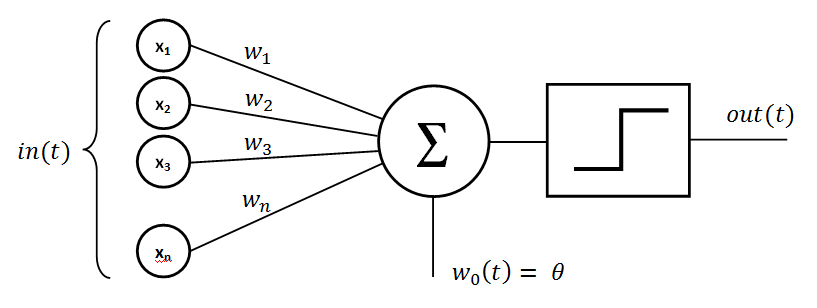

Source: https://pl.wikipedia.org/wiki/Perceptron#/media/Plik:Perceptron_moj.png

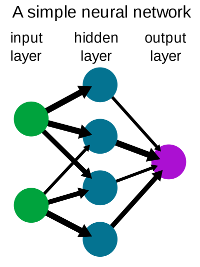

Source: https://en.wikipedia.org/wiki/Neural_network

A deep neural network (DNN) is an artificial neural network (ANN) with more complex architecture within a number of layers. The DNN during a learning process adapts to data and gathered knowledge is stored in weights conecting artificial neurons. Development and learning of a very complex neural network require a specific approach called deep learning which is related to technics preventing overfitting as well as reduce the time required to learn the model. DNN could have some specilized layers introduced like filters responsible for data convolution (Convolutional Neural Networks).


# 2. Problem - predict if given chemical compound is agonist of estrogen nuclear receptor alpha

The 2014 Tox21 data challenge was designed to develop models capable to predict the affinity of chemical compounds to specific receptors. General idea was to develop a tools with possible applications in searching for new active compounds and perform screening in search of new potential drugs. We will focus on the assessment of compound affinity to estrogen alpha receptors. 

qHTS assay to identify small molecule agonists of the estrogen receptor alpha (ER-alpha) signaling pathway using the BG1 cell line

Tox21 challange: https://tripod.nih.gov/tox21/challenge/index.jsp

Dataset we will explore: https://pubchem.ncbi.nlm.nih.gov/bioassay/743079

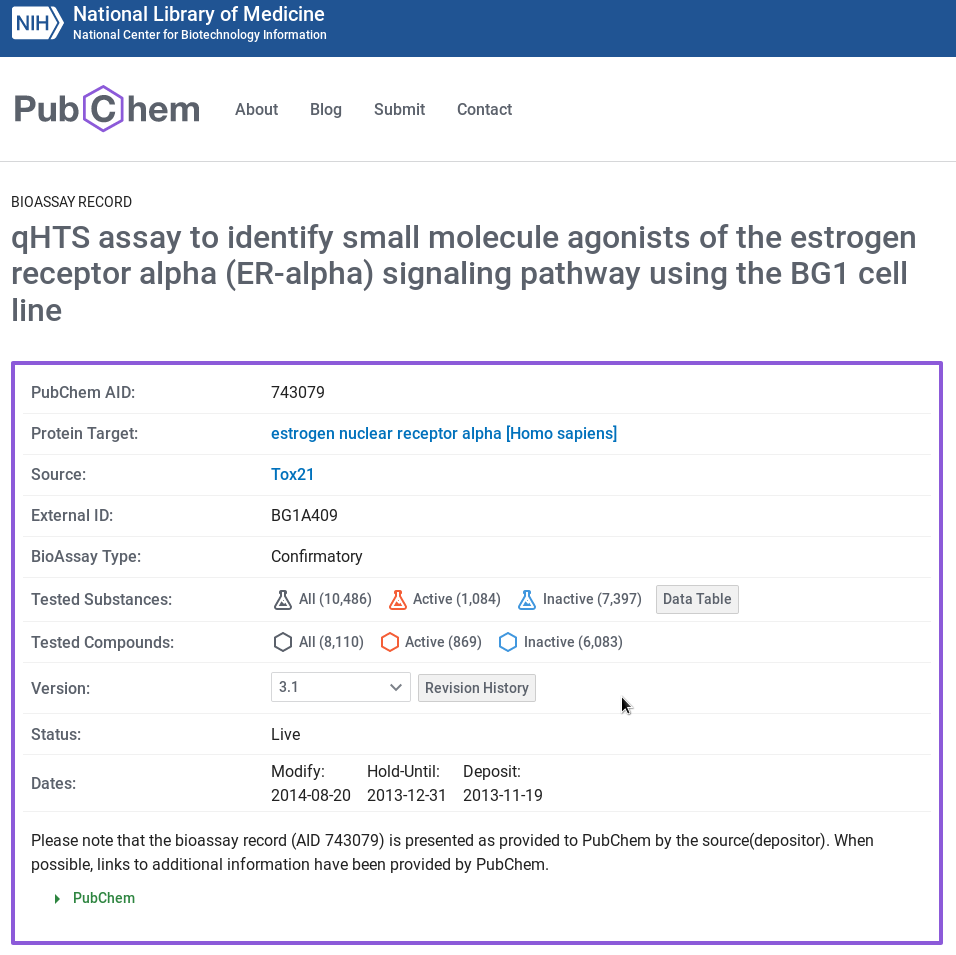

In [55]:
##Import all required packages
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn import linear_model
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import *
from keras.wrappers.scikit_learn import *
#Load the data
df_raw = pd.read_csv("estrogen_nuclear_receptor.txt", sep="\t")

#Function to calculate fingerprints with specified length of binary outcome
def morgan_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=10000)
    npfp=np.array(list(fp.ToBitString())).astype('float').T
    return npfp

In [56]:
#Calculate fingerprints
data=np.array([np.arange(df_raw.shape[0])]*10000).T
for i, row in df_raw.iterrows():
    data[i]=morgan_fp(df_raw["SMILES"][i])

In [57]:
data.shape

(8472, 10000)

In [58]:
#Create input and output vectors of variables
X=data
y=pd.DataFrame(df_raw['Agonist'])

In [ ]:
#Define model architecture and perform 10-cv calculations
def DNN_model():
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu',    kernel_regularizer=l1_l2(l1=0.0, l2=0.5)))
    model.add(Dropout(0.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu', kernel_regularizer=l1_l2(l1=0.0, l2=0.5)))
    model.add(Dropout(0.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu', kernel_regularizer=l1_l2(l1=0.0, l2=0.5)))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

dnn = KerasClassifier(build_fn=DNN_model, epochs=10, batch_size=1000, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
results = cross_validate(dnn, 
                        X_train, 
                        y_train, 
                        cv=kfold, 
                        scoring=['accuracy', 'balanced_accuracy', 'roc_auc', 'f1'], 
                        return_train_score=True, 
                        return_estimator=True)


Epoch 1/10
7624/7624 [==============================] - 3s 407us/step - loss: 35.2508 - accuracy: 0.8804
Epoch 2/10
7624/7624 [==============================] - 2s 226us/step - loss: 27.4642 - accuracy: 0.8804
Epoch 3/10
7624/7624 [==============================] - 1s 184us/step - loss: 21.1134 - accuracy: 0.8804
Epoch 4/10
7624/7624 [==============================] - 1s 156us/step - loss: 16.1704 - accuracy: 0.8804
Epoch 5/10
7624/7624 [==============================] - 1s 166us/step - loss: 12.4149 - accuracy: 0.8804
Epoch 6/10
7624/7624 [==============================] - 1s 174us/step - loss: 9.5650 - accuracy: 0.8804
Epoch 7/10
7624/7624 [==============================] - 1s 169us/step - loss: 7.4035 - accuracy: 0.8804
Epoch 8/10
7624/7624 [==============================] - 1s 177us/step - loss: 5.7670 - accuracy: 0.8804
Epoch 9/10
7624/7624 [==============================] - 1s 184us/step - loss: 4.5229 - accuracy: 0.8804
Epoch 10/10
7624/7624 [==============================] - 1s

7625/7625 [==============================] - 1s 153us/step - loss: 9.2178 - accuracy: 0.8803
Epoch 7/10
7625/7625 [==============================] - 1s 150us/step - loss: 7.1171 - accuracy: 0.8803
Epoch 8/10
7625/7625 [==============================] - 1s 158us/step - loss: 5.5246 - accuracy: 0.8803
Epoch 9/10
7625/7625 [==============================] - 1s 163us/step - loss: 4.3152 - accuracy: 0.8803
Epoch 10/10
7625/7625 [==============================] - 1s 108us/step
Epoch 1/10
7625/7625 [==============================] - 6s 784us/step - loss: 34.1643 - accuracy: 0.8803
Epoch 2/10
7625/7625 [==============================] - 1s 180us/step - loss: 26.5607 - accuracy: 0.8803
Epoch 3/10
7625/7625 [==============================] - 1s 176us/step - loss: 20.4305 - accuracy: 0.8803
Epoch 4/10
7625/7625 [==============================] - 1s 159us/step - loss: 15.6460 - accuracy: 0.8803
Epoch 5/10
7625/7625 [==============================] - 1s 162us/step - loss: 11.9889 - accuracy: 0.8803

In [64]:
results['test_roc_auc']

{'fit_time': array([118.74217892, 111.05812097, 118.52625012, 127.69321537,
        117.79111862, 120.28922796, 122.0893321 , 126.15829253,
        125.78135157, 133.53012562]),
 'score_time': array([0.46792293, 0.37630415, 2.74190092, 0.41623378, 0.35397983,
        2.65362167, 2.59019184, 1.95253706, 2.77430415, 3.10672784]),
 'estimator': (<keras.wrappers.scikit_learn.KerasClassifier at 0x7f89850fe5c0>,
  <keras.wrappers.scikit_learn.KerasClassifier at 0x7f893b07b978>),
 'test_accuracy': array([0.87971698, 0.87971698, 0.88075561, 0.88075561, 0.88075561,
        0.88075561, 0.88075561, 0.88075561, 0.87957497, 0.87957497]),
 'train_accuracy': array([0.88037775, 0.88037775, 0.8802623 , 0.8802623 , 0.8802623 ,
        0.8802623 , 0.8802623 , 0.8802623 , 0.88039344, 0.88039344]),
 'test_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'train_balanced_accuracy': array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
 'test_roc_auc': array([0.54076644, 0.

In [229]:
#Compare with a Linear model
fitscores = []
alphas = np.logspace(-2, 4, num=10)
for alpha in alphas:
    estimator = linear_model.LogisticRegression(C = 1/alpha)
      

    results = cross_validate(estimator, 
                                         X_train, 
                                         y_train, 
                                         cv=kfold, 
                                         scoring=['accuracy', 'roc_auc', 'f1'], 
                                         return_train_score=True, 
                                         return_estimator=True)
    
    fitscores.append(results)

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y 

/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/adam/anaconda3/envs/regression/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [230]:
fitscores

[{'fit_time': array([7.48042917, 6.38767385, 6.08726859, 6.08746243, 6.3068459 ,
         6.13200331, 6.33558989, 6.00037503, 6.14705253, 5.99856544]),
  'score_time': array([0.09256196, 0.03329754, 0.03242826, 0.03232718, 0.0276804 ,
         0.03450823, 0.03423858, 0.0318563 , 0.03415322, 0.03790474]),
  'estimator': (LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=False),
   LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                      intercept_scaling=1, l1_ratio=None, max_iter=100,
                      multi_class='auto', n_jobs=None, penalty='l2',
                      random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                      warm_start=F

Questions and suggestions are highly welcome! adam.paclawski@uj.edu.pl